There are two major intermidiate steps when solving chess problem:
1. Move Chess:

>> Objective: find the shortest path between 2 spots on a chess board

>> Motivation: Move Chess effectively

2. Capture Chess

>> Objective: capture as many pieces from the opponent within centain fullmoves

>> Motivation: Piece captures as one way of reward.


Today we focus on Move chess

# Load and Import Package

In [ ]:
!pip install --upgrade git+https://github.com/arjangroen/RLC.git 
!pip install python-chess  
# Python-Chess is the Python Chess Package that handles the chess environment

In [ ]:
from RLC.move_chess.environment import Board
from RLC.move_chess.agent import Piece
from RLC.move_chess.learn import Reinforce
import inspect

In [ ]:
print(inspect.getsource(Reinforce))
# play episodes, train and evaluate value and policy function 

In [ ]:
print(inspect.getsource(Piece)) # choose agent, apply policy, set move rule

In [ ]:
print(inspect.getsource(Board)) # take step, render chess board

# Load Chess

In [ ]:
p = Piece(piece='king') # select a chess agent (knight, bishop or rook)
env = Board() # 8*8 chess board
r = Reinforce(p,env) 
env.render()
env.visual_board # S start position, F is terminate position

[['[S]', '[ ]', '[ ]', '[ ]', '[ ]', '[ ]', '[ ]', '[ ]'],
 ['[ ]', '[ ]', '[ ]', '[ ]', '[ ]', '[ ]', '[ ]', '[ ]'],
 ['[ ]', '[ ]', '[ ]', '[ ]', '[ ]', '[ ]', '[ ]', '[ ]'],
 ['[ ]', '[ ]', '[ ]', '[ ]', '[ ]', '[ ]', '[ ]', '[ ]'],
 ['[ ]', '[ ]', '[ ]', '[ ]', '[ ]', '[ ]', '[ ]', '[ ]'],
 ['[ ]', '[ ]', '[ ]', '[ ]', '[ ]', '[ ]', '[ ]', '[ ]'],
 ['[ ]', '[ ]', '[ ]', '[ ]', '[ ]', '[ ]', '[ ]', '[ ]'],
 ['[ ]', '[ ]', '[ ]', '[ ]', '[ ]', '[F]', '[ ]', '[ ]']]

# Temporal Difference Learning
We update our state-action value in the direction of the successor state action value.

The algorithm is called SARSA: State-Action-Reward-State-Action.


# Algorithm

TD(0): actual action value

$Q(s, a) = Q(s, a) + \alpha (r + \gamma*Q(s' , a' )-Q(s, a))$

In [ ]:
def sarsa_td(self, n_episodes=1000, alpha=0.01, gamma=0.9):
        """
        Run the sarsa control algorithm (TD0), 
        finding the optimal policy and action function
        :param n_episodes: int, amount of episodes to train
        :param alpha: learning rate
        :param gamma: discount factor of future rewards
        :return: finds the optimal policy for move chess
        """
        for k in range(n_episodes):
            state = (0, 0)
            self.env.state = state
            episode_end = False
            epsilon = max(1 / (1 + k), 0.05)
            while not episode_end:
                state = self.env.state
                action_index = self.agent.apply_policy(state, epsilon)
                action = self.agent.action_space[action_index]
                reward, episode_end = self.env.step(action)
                successor_state = self.env.state
                successor_action_index = 
                self.agent.apply_policy(successor_state, epsilon) #diff

                action_value = self.agent.action_function[state[0], 
                                                          state[1], 
                                                          action_index]
                successor_action_value = 
                self.agent.action_function[successor_state[0],
                                           successor_state[1], 
                                           successor_action_index]

                q_update = alpha * (reward + gamma * successor_action_value -
                                    action_value)

                self.agent.action_function[state[0], 
                                           state[1], 
                                           action_index] += q_update
                self.agent.policy = self.agent.action_function.copy()

In [ ]:
def TD_zero(self, epsilon=0.1, alpha=0.05, max_steps=1000, lamb=0.9):
        """
        Find the value function of move chess states
        :param epsilon: exploration rate
        :param alpha: learning rate
        :param max_steps: max amount of steps in an episode
        """
        state = (0, 0)
        self.env.state = state
        states = []
        actions = []
        rewards = []
        episode_end = False
        count_steps = 0
        while not episode_end:
            count_steps += 1
            states.append(state)
            action_index = self.agent.apply_policy(state, epsilon=epsilon)
            action = self.agent.action_space[action_index]
            actions.append(action)
            reward, episode_end = self.env.step(action)
            suc_state = self.env.state
            self.agent.value_function[state[0], state[1]] = self.agent.value_function[state[0], state[1]] + alpha * (
                    reward + lamb * self.agent.value_function[suc_state[0], suc_state[1]] - self.agent.value_function[
                state[0], state[1]])
            state = self.env.state

            if count_steps > max_steps:
                episode_end = True

TD(lambda): eligibility-trace to keep track of the previously encountered states

$E_t(s) = \gamma \lambda E_{t-1}(s)+1(S_t = s)$

$Q(s, a) = Q(s, a) + \alpha (r + \gamma*Q(s' , a' )-Q(s, a))E_t(s)$

In [ ]:
def sarsa_lambda(self, n_episodes=1000, alpha=0.05, gamma=0.9, lamb=0.8):
        """
        Run the sarsa control algorithm (TD lambda), 
        finding the optimal policy and action function
        :param n_episodes: int, amount of episodes to train
        :param alpha: learning rate
        :param gamma: discount factor of future rewards
        :param lamb: lambda parameter describing the decay over n-step returns
        :return: finds the optimal move chess policy
        """
        for k in range(n_episodes):
            self.agent.E = np.zeros(shape=self.agent.action_function.shape)
            state = (0, 0)
            self.env.state = state
            episode_end = False
            epsilon = max(1 / (1 + k), 0.2)
            action_index = self.agent.apply_policy(state, epsilon)
            action = self.agent.action_space[action_index]
            while not episode_end:
                reward, episode_end = self.env.step(action)
                successor_state = self.env.state
                successor_action_index = 
                self.agent.apply_policy(successor_state, epsilon) 

                action_value = self.agent.action_function[state[0], 
                                                          state[1], 
                                                          action_index]
                if not episode_end:
                    successor_action_value = 
                    self.agent.action_function[successor_state[0],
                                               successor_state[1], 
                                               successor_action_index]
                else:
                    successor_action_value = 0
                delta = reward + gamma * successor_action_value - action_value
                self.agent.E[state[0], state[1], action_index] += 1
                self.agent.action_function = self.agent.action_function + 
                alpha * delta * self.agent.E
                self.agent.E = gamma * lamb * self.agent.E
                state = successor_state
                action = self.agent.action_space[successor_action_index]
                action_index = successor_action_index
                self.agent.policy = self.agent.action_function.copy()

In [ ]:
r.sarsa_td(n_episodes=1000, alpha=0.05, gamma=0.9)
states, actions, rewards = r.play_episode(state = (0,0), 
                                          max_steps=1e3, epsilon=0.1)
len(actions)

8

In [ ]:
r.sarsa_lambda(n_episodes=1000, alpha=0.05, gamma=0.9, lamb=0.8)
states, actions, rewards = r.play_episode(state = (0,0), 
                                          max_steps=1e3, epsilon=0.1)
len(actions)

8

# Visualize the learning progress

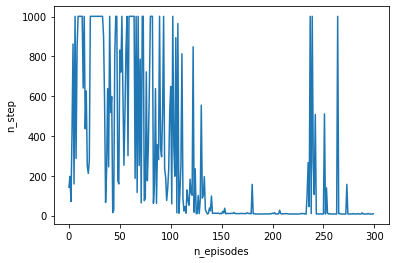

In [ ]:
p = Piece(piece='king') # select a chess agent (knight, bishop or rook)
env = Board() # 8*8 chess board
r = Reinforce(p,env) 
eva = [] # numnbe of step to get to desired position

for i in range(300):
  r.sarsa_td(n_episodes=1, alpha=0.05, gamma=0.9)
  states, actions, rewards = r.play_episode(state = (0,0), 
                                            max_steps=1e3, epsilon=0.1)
  eva.append(len(actions))
import matplotlib.pyplot as plt
plt.plot(eva)
plt.xlabel('n_episodes')
plt.ylabel('n_step')
plt.show()


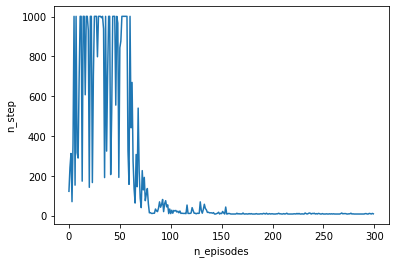

In [ ]:
p = Piece(piece='king') # select a chess agent (knight, bishop or rook)
env = Board() # 8*8 chess board
r = Reinforce(p,env) 
eva = [] # numnbe of step to get to desired position

for i in range(300):
  r.sarsa_lambda(n_episodes=1, alpha=0.05, gamma=0.9)
  states, actions, rewards = r.play_episode(state = (0,0), 
                                            max_steps=1e3, epsilon=0.1)
  eva.append(len(actions))

plt.plot(eva)
plt.xlabel('n_episodes')
plt.ylabel('n_step')
plt.show()